In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# Step 1: Define the Neural Network model
def build_model():
    model = Sequential([
        Dense(100, activation='relu', input_shape=(1,)),
        Dense(100, activation='relu'),
        Dense(100, activation='relu'),
        #Dense(100, activation='relu'),
        Dense(1, activation='linear')
    ])
    return model

In [3]:
# Step 2: Define the physics-informed loss function
def physics_informed_loss(x, y_pred):
    # Compute the derivative of the model's output y with respect to x
    with tf.GradientTape() as tape:
        tape.watch(x)
        y = model(x)
    dy_dx = tape.gradient(y, x)

    # Physics-informed loss (PDE constraint): dy/dx + y = 0
    physics_loss = dy_dx + y

    # Compute the Mean Squared Error of the physics loss
    return tf.reduce_mean(tf.square(physics_loss))

In [4]:
# Step 3: Generate training data
x_train = np.random.uniform(0, 2, 100).reshape(-1, 1)  # Sample points from the domain [0, 2]
y_train = np.exp(-x_train)  # True solution y = e^{-x}

# Convert training data to TensorFlow tensors
x_train_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [5]:
# Step 4: Build and compile the model
model = build_model()
optimizer = Adam(learning_rate=0.001)

# Custom training loop
epochs = 6000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        y_pred = model(x_train_tensor)
        # data loss
        data_loss = tf.reduce_mean(tf.square(y_train - y_pred))  # Mean squared error
        # Physics-informed loss
        pde_loss = physics_informed_loss(x_train_tensor, y_pred)
        # Total loss is a weighted sum of both losses
        loss = pde_loss + data_loss

    # Compute gradients and update model weights
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Print the loss value periodically
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy()}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 0: Loss = 0.19052846729755402
Epoch 500: Loss = 0.0008692953852005303
Epoch 1000: Loss = 0.00031217074138112366
Epoch 1500: Loss = 0.00020039510854985565
Epoch 2000: Loss = 0.00028811232186853886
Epoch 2500: Loss = 0.0004992859321646392
Epoch 3000: Loss = 0.00044554212945513427
Epoch 3500: Loss = 0.0003743343986570835
Epoch 4000: Loss = 0.0003362157440278679
Epoch 4500: Loss = 0.00041089553269557655
Epoch 5000: Loss = 0.0004128029104322195
Epoch 5500: Loss = 0.0003427633491810411


In [6]:
# Step 5: Test the trained model
x_test = np.linspace(0, 2, 100).reshape(-1, 1)
y_test = np.exp(-x_test)

# Predict the solution with the trained model
y_pred = model.predict(x_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


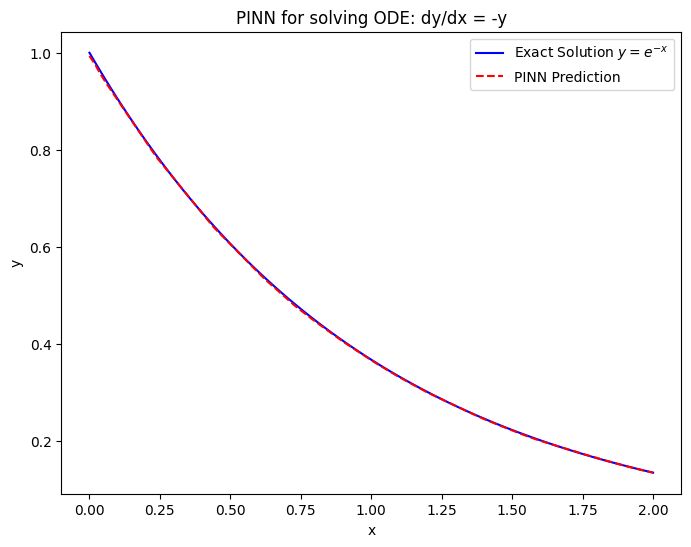

In [7]:
# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(x_test, y_test, label='Exact Solution $y = e^{-x}$', color='blue')
plt.plot(x_test, y_pred, label='PINN Prediction', color='red', linestyle='dashed')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('PINN for solving ODE: dy/dx = -y')
plt.show()
